In [1]:
# Logistic Regression

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Importing the dataset
train = pd.read_csv(r'C:\PYTHON LEARNING\DATA\titanic_train.csv')

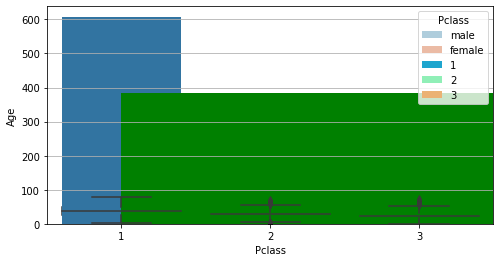

In [2]:
#EDA
sns.countplot(x='Survived',data=train,palette='RdBu_r')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)
sns.countplot(x='SibSp',data=train)
train['Fare'].hist(color='green',bins=40,figsize=(8,4))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

KeyError: "['Cabin'] not found in axis"

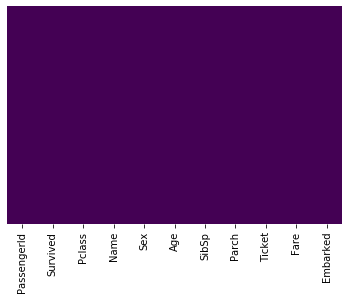

In [9]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
# Taking care of missing data

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return train.groupby('Pclass').mean()['Age'].iloc[0]

        elif Pclass == 2:
            return train.groupby('Pclass').mean()['Age'].iloc[1]

        else:
            return train.groupby('Pclass').mean()['Age'].iloc[2]

    else:
        return Age


train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

train.drop('Cabin', axis=1, inplace=True)
train.dropna(inplace=True)

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


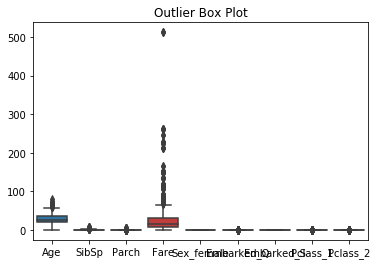

In [11]:
X = train.iloc[:, [2, 4, 5, 6, 7, 9, 10]]
y = train.iloc[:, 1]
multicolinearity_check = train.corr()


# Encoding categorical data
sex = pd.get_dummies(X['Sex'], prefix = 'Sex')
sex.drop('Sex_male', inplace = True, axis=1)

embark = pd.get_dummies(X['Embarked'], prefix = 'Embarked', drop_first=True)

passenger_class = pd.get_dummies(X['Pclass'], prefix = 'Pclass')
passenger_class.drop('Pclass_3', inplace = True, axis=1)

X.drop(['Sex','Embarked','Pclass'],axis=1,inplace=True)
X = pd.concat([X,sex,embark, passenger_class],axis=1)

#Outliners
sns.boxplot(data= X).set_title("Outlier Box Plot")

linearity_check_df = pd.concat([pd.DataFrame(X),y],axis=1)

KeyError: 'Sex_male'

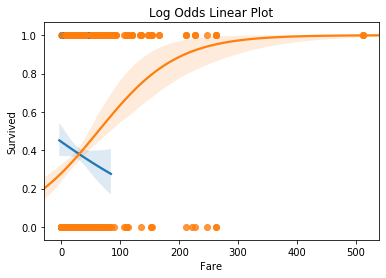

In [12]:
sns.regplot(x= 'Age', y= 'Survived', data= linearity_check_df, logistic= True).set_title("Log Odds Linear Plot")
sns.regplot(x= 'Fare', y= 'Survived', data= linearity_check_df, logistic= True).set_title("Log Odds Linear Plot")
sns.regplot(x= 'Sex_male', y= 'Survived', data= linearity_check_df, logistic= True).set_title("Log Odds Linear Plot")


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [13]:
# Feature Scaling #Need to be done after splitting
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train.iloc[:, [0,3]] = sc.fit_transform(X_train.iloc[:, [0,3]])
X_test.iloc[:, [0,3]] = sc.transform(X_test.iloc[:, [0,3]])


NameError: name 'X_train' is not defined

In [14]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [15]:
#Find relevant features
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

NameError: name 'X_train' is not defined

In [16]:
from sklearn.feature_selection import RFE

rfe = RFE(classifier, rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

# Can select columns based on the returned mask
# X.loc[:, rfe.support_]


# Predicting the Test set results
y_pred = classifier.predict(X_test)





# K-Fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
model_accuracy = accuracies.mean()
model_standard_deviation = accuracies.std()






# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


#Genarate Reports
import statsmodels.api as sm

#X_set = X[['Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2']]
X_set = X.loc[:, rfe.support_]
X_set = sm.add_constant(X_set)

logit_model=sm.Logit(y,X_set)
result=logit_model.fit()
print(result.summary2())


# GETTING THE ODDS RATIOS, Z-VALUE, AND 95% CI
model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())








#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
area_under_curve = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

AttributeError: 'RFECV' object has no attribute 'n_features_'